### Greedy Snake Algorithm

In [1]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

Cloning into 'cs4250'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 65 (delta 19), reused 53 (delta 11), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
import numpy as np
from numpy.linalg import norm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  

Energy computation:
* Use the gradient magnitude as image term.
* Calculate the three energy terms $E_{cont}$, $E_{curv}$, and $E_{imag}$.
* Normalize the energy terms over the neighborhood to the intervall $[0,1]$.
* Estimate the point in the neighborhood, that has minimum energy.


In [3]:
def snake(img, contour, **kwargs):
    # parameter initialization
    k = contour.shape[1]
    alpha = kwargs['alpha'] * np.ones(k)
    beta = kwargs['beta'] * np.ones(k)
    gamma = kwargs['gamma'] * np.ones(k)

    # : compute gradient image
    gradient_x, gradient_y = gradient(image)
    grad_magn = np.sqrt(gradient_x*gradient_x + gradient_y*gradient_y)
    norm_image_gradient = grad_magn#(grad_magn - np.min(grad_magn)) / (np.max(grad_magn) - np.min(grad_magn))

    k_updated = k
    iterations = 0
    # iterate until snake stops changing
    while k_updated > k * kwargs['contour_fraction']:
        iterations = iterations + 1
        k_updated = 0
        
        # update all contour points
        for i in range(k):
            p, updated = greedy_minimization(
                norm_image_gradient, contour, i, alpha, beta, gamma, kwargs['neighborhood_size'])
            if p is not None:
                contour[:, i] = p
            # eliminate corners if required
            if iterations > kwargs['begin_corner_elim']:
                beta = corner_elimination(contour, beta, kwargs['K_threshold'])
            
            # keep track of number of updated points
            if updated:
                k_updated = k_updated + 1
        
        # display current state of snake
        print('num_updates: {}'.format(k_updated))
        plt.imshow(norm_image_gradient)
        plt.plot(contour[1, :], contour[0, :], 'r.-')
        plt.show()

In [4]:
def greedy_minimization(norm_image_gradient, contour, i, alpha, beta, gamma, neighborhood_size):
    m, n = norm_image_gradient.shape
    k = contour.shape[1]
    w = (kwargs['neighborhood_size'] - 1.) // 2.
    d = average_distance(contour)
    updated = False

    # get previous, current, and next point in snake
    p_iminus1 = contour[:, wrap_index(i-1, k)]
    p_i = contour[:, i]
    p_iplus1 = contour[:, wrap_index(i+1, k)]

    # compute individual terms of energy functional

    p = []
    E_cont = []
    E_curv = []
    E_imag = []

    # For all points in a local neighborhood, compute the energy terms
    for p_i_x in np.arange(max(0, p_i[0] - w), min(m-1, p_i[0]+w)+1):
        for p_i_y in np.arange(max(0, p_i[1]-w), min(n-1, p_i[1]+w)+1):
          # : get the respective vector
          p_ = np.array([p_i_x, p_i_y])
          p.append(p_)

          # : compute energy terms
          pts1 = p_ - p_iminus1
          pts2 = p_ - p_iplus1

          E_cont.append(np.square(0.5 * (norm(pts1) - norm(pts2))))
          E_curv.append(np.square(norm(p_iminus1 - 2*p_ + p_iplus1)))
          E_imag.append(-norm(norm_image_gradient[int(p_i_x), int(p_i_y)]))

    if not p:
        return None, False


    # : normalize individual terms of energy functional

    E_cont = (E_cont - np.min(E_cont)) / (np.max(E_cont) - np.min(E_cont))
    E_curv = (E_curv - np.min(E_curv)) / (np.max(E_curv) - np.min(E_curv))
    E_imag = (E_imag - np.min(E_imag)) / (np.max(E_imag) - np.min(E_imag))


    # compute energy functional and determine minimum
    E = np.multiply(alpha[i], E_cont) + np.multiply(beta[i], E_curv) + np.multiply(gamma[i], E_imag)
    
    new_p_i = p[np.argmin(E)]
    
    # determine if current point of snake was moved
    if (p_i - new_p_i).sum() != 0:
        updated = True
    
    return new_p_i, updated

In [5]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y

In [6]:
def load_image_gray_normalized(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image.astype('float32')/255.

In [7]:
def wrap_index(index, k):
    if index < 0:
        index = k - 1
    elif index > k-1:
        index = 0
    return index

In [8]:
def average_distance(contour):
    avg_dist = 0
    n = contour.shape[1]

    for i in range(n-1):
        avg_dist = avg_dist+norm(contour[:, i] - contour[:, i+1])

    avg_dist = avg_dist+norm(contour[:, -1] - contour[:, 0])
    avg_dist = avg_dist / n

    return avg_dist

In [9]:
def corner_elimination(contour, beta, K_threshold):
    n = contour.shape[1]
    K = []
    # compute curvature of snake at each point
    for i in range(n):
        # get previous, current, and next point in snake
        p_iminus1 = contour[:, wrap_index(i-1, n)]
        p_i = contour[:, i]
        p_iplus1 = contour[:, wrap_index(i+1, n)]
        K.append(((p_iminus1 - 2.*p_i + p_iplus1)**2.).sum())

    # determine local maxima and set beta to zero there
    for i in range(n):
        non_lower = K[wrap_index(i-1, n)] < K[i]
        non_higher = K[i] > K[wrap_index(i+1, n)]
        grt_thres = K[i] > K_threshold
        if non_lower and non_higher and grt_thres:
            beta[i] = 0
    
    return beta

## Testing

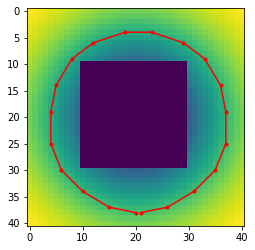

num_updates: 19


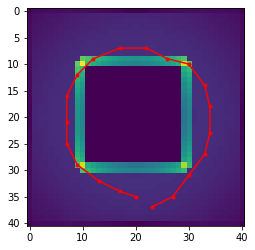

num_updates: 19


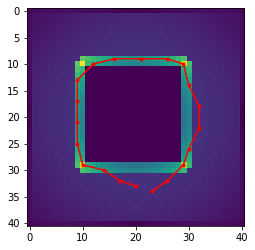

num_updates: 9


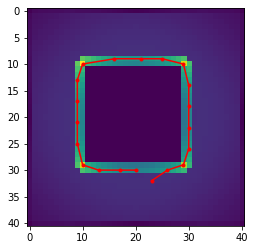

num_updates: 4


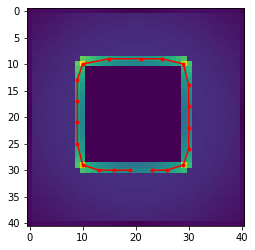

num_updates: 1


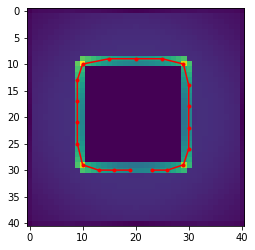

In [10]:
# load image
input_dict = np.load('data/exercise_4/ueb422.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
snake(image, contour, **kwargs)

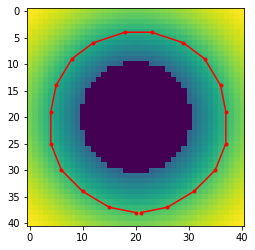

num_updates: 20


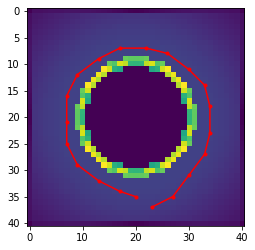

num_updates: 19


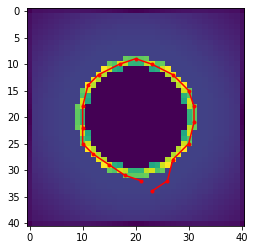

num_updates: 9


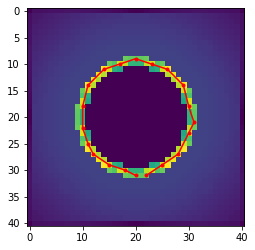

num_updates: 3


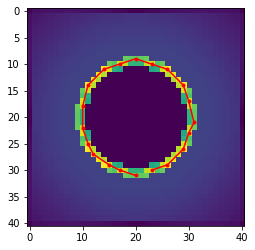

num_updates: 2


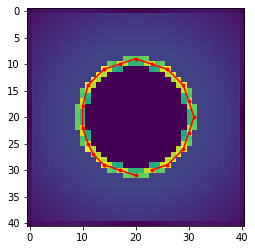

In [11]:
# load image
input_dict = np.load('data/exercise_4/ueb421.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
snake(image, contour, **kwargs)

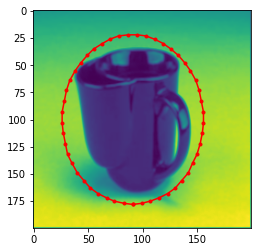

num_updates: 34


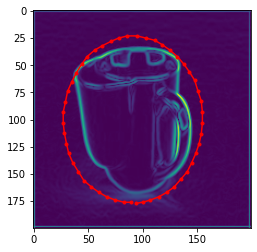

num_updates: 30


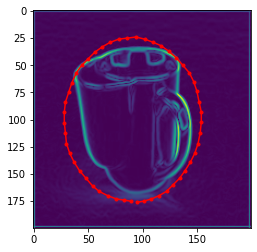

num_updates: 37


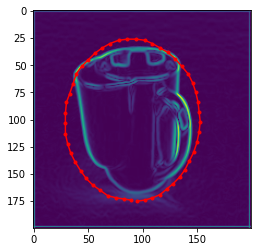

num_updates: 38


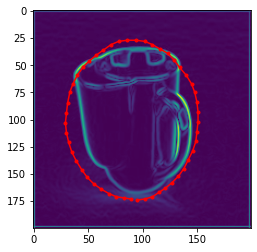

num_updates: 36


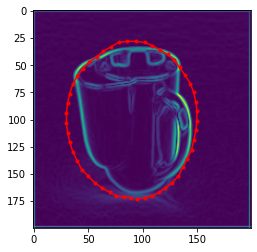

num_updates: 33


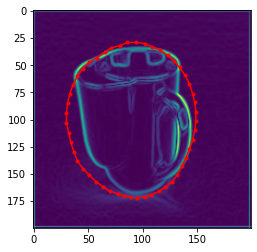

num_updates: 39


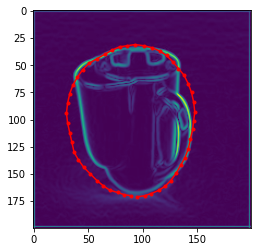

num_updates: 33


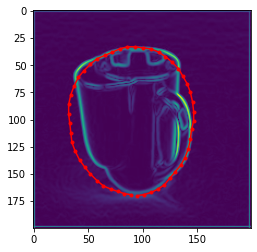

num_updates: 35


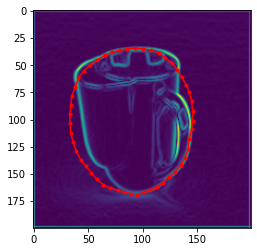

num_updates: 35


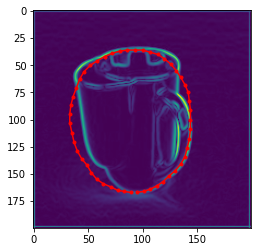

num_updates: 26


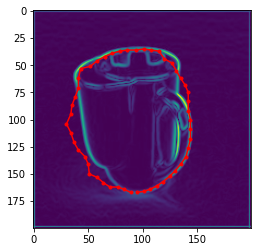

num_updates: 19


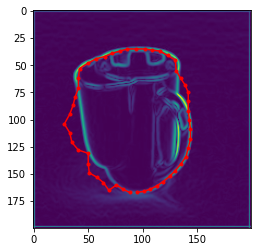

num_updates: 16


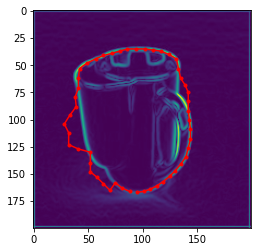

num_updates: 18


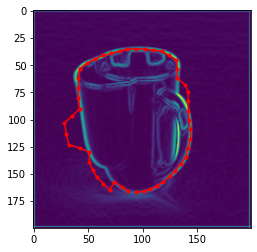

num_updates: 14


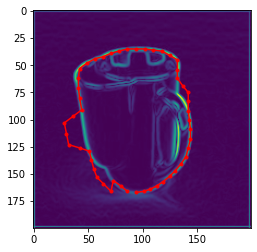

num_updates: 13


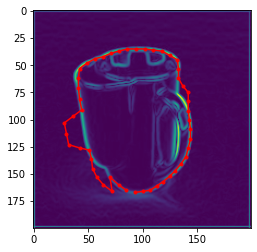

num_updates: 13


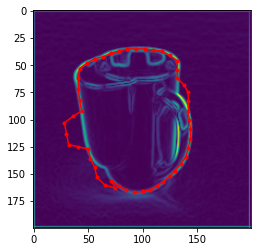

num_updates: 11


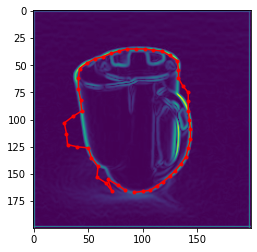

num_updates: 8


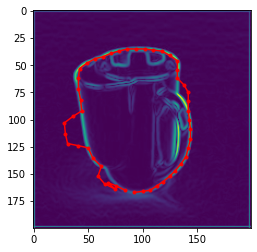

num_updates: 9


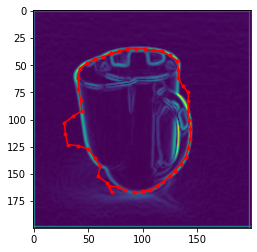

num_updates: 6


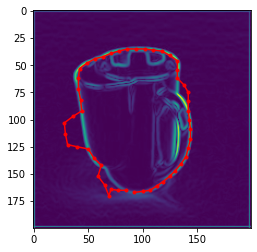

num_updates: 6


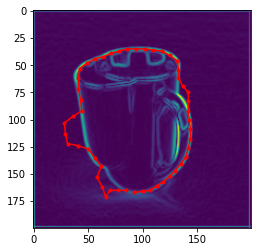

num_updates: 8


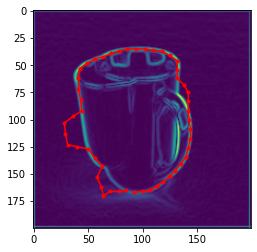

num_updates: 7


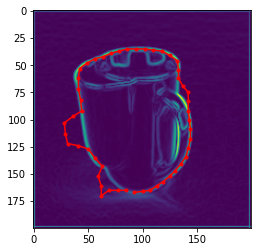

num_updates: 6


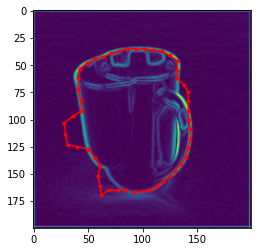

num_updates: 7


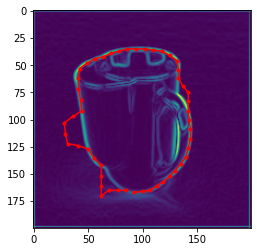

num_updates: 8


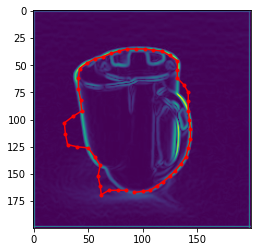

num_updates: 6


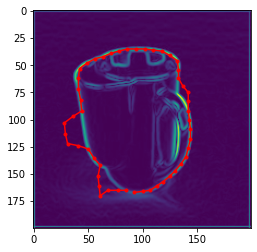

num_updates: 8


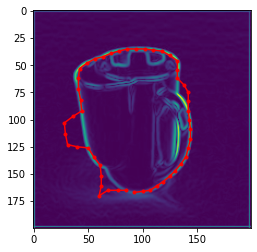

num_updates: 9


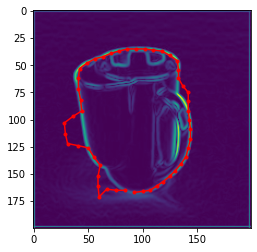

num_updates: 7


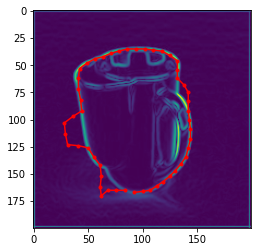

num_updates: 7


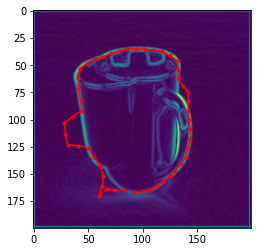

num_updates: 7


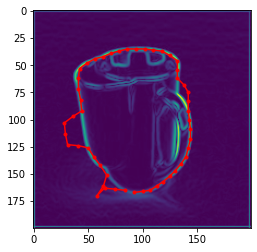

num_updates: 5


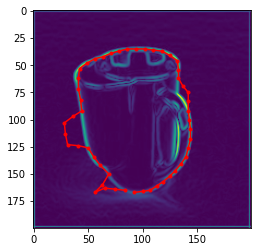

In [12]:
# load image
input_dict = np.load('data/exercise_4/ueb423.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 10.,
    'beta': 10.,
    'gamma': 0.6,
    'begin_corner_elim': 10,
    'K_threshold': 1
}
# run snake
snake(image, contour, **kwargs)